In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from pickle import dump, load
import string
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [11]:
class CaptionGenerator:
    
    IMAGE_WIDTH = 0
    IMAGE_HEIGHT = 0
    
    IMAGE_CLASSIFIER = None
    
    def __init__(self, image_width, image_height):
        self.IMAGE_WIDTH = image_width
        self.IMAGE_HEIGHT = image_height
        
        #self.IMAGE_CLASSIFIER = ImageClassifier(image_width, image_height)
        #self.IMAGE_CLASSIFIER.loadModel()
        
    def calculateDescriptionMaxLength(self, descriptions):
        lines = self.convertToLines(descriptions)
        return max(len(d.split()) for d in lines)
        
    def cleanDescriptions(self, descriptions):
        table = str.maketrans('', '', string.punctuation)
        for key, description_list in descriptions.items():
            for i in range(len(description_list)):
                description = description_list[i]
                description = description.split()
                description = [word.lower() for word in description]
                description = [w.translate(table) for w in description]
                description = [word for word in description if len(word)>1]
                description = [word for word in description if word.isalpha()]
                description_list[i] = ' '.join(description)
        
    def convertPath(self, path):
        validPath = ""
        for char in path:
            if char == '\\':
                validPath += "/"
            else:
                validPath += char
        return validPath
    
    def convertToLines(self, descriptions):
        all_descriptions = list()
        for key in descriptions.keys():
            [all_descriptions.append(d) for d in descriptions[key]]
        return all_descriptions
    
    def convertToVocabulary(self, descriptions):
        all_descriptions = set()
        for key in descriptions.keys():
            [all_descriptions.update(d.split()) for d in descriptions[key]]
        return all_descriptions
    
    def createSequences(self, tokenizer, max_length, description_list, photos, vocab_size):
        X1, X2, y = list(), list(), list()
        for description in description_list:
            sequence = tokenizer.texts_to_sequences([description])[0]
            for i in range(1, len(sequence)):
                in_sequence, out_sequence = sequence[:i], sequence[i]
                in_sequence = pad_sequences([in_sequence], maxlen=max_length)[0]
                out_sequence = to_categorical([out_sequence], num_classes=vocab_size)[0]

                X1.append(photos[key][0])
                X2.append(in_sequence)
                y.append(out_sequence)
        return np.array(X1), np.array(X2), np.array(y)
    
    def createTokenizer(self, descriptions):
        lines = self.convertToLines(descriptions)
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(lines)
        return tokenizer
    
    def dataGenerator(self, descriptions, photos, tokenizer, max_length, vocab_size):
        while 1:
            for key, description_list in descriptions.items():
                photo = photos[key][0]
                in_img, in_seq, out_word = self.createSequences(tokenizer, max_length, descriptions, photo, vocab_size)
                yield [in_img, in_seq], out_word
    
    def defineCaptioningModel(self, vocab_size, max_length, summarize=False):
        # Feature extractor model
        inputs1 = Input(shape=(4096,))
        fe1 = Dropout(0.5)(inputs1)
        fe2 = Dense(256, activation="relu")(fe1)
        
        # Sequence model
        inputs2 = Input(shape=(max_length,))
        se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
        se2 = Dropout(0.5)(se1)
        se3 = LSTM(256)(se2)
        
        # Decoder model
        decoder1 = add([fe2, se3])
        decoder2 = Dense(256, activation="relu")(decoder1)
        outputs = Dense(vocab_size, activation="softmax")(decoder2)
        
        model = Model(inputs=[inputs1, inputs2], outputs=outputs)
        model.compile(loss="categorical_crossentropy", optimizer="adam")
        
        if summarize:
            print(model.summary())
            
        plot_model(model, to_file="model.png", show_shapes=True)
        
        return model
        
    def extractFeatures(self, directory, output_file="features.pkl", verbose=1):
        model =  model = VGG16()
        model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
        if(verbose >= 2):
            print(model.summary())
    
        features = dict()
        for name in os.listdir(directory):
            filename = directory + '/' + name
            image = load_img(filename, target_size=(self.IMAGE_WIDTH, self.IMAGE_HEIGHT))
            image = img_to_array(image)
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
            image = preprocess_input(image)
            feature = model.predict(image, verbose=0)
            image_id = name.split('.')[0]
            features[image_id] = feature
            if(verbose >= 3):
                print('>%s' % name)
                
        if verbose >= 1:
            print("Extracted Features: %d" % len(features))
            
        dump(features, open(output_file, 'wb'))
        
        return features
    
    def fitCaptioningModel(self):
        filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
        checkpoint = ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, mode='min')
    
    def generateCaption(self, image_path, prediction_model_path="ImageClassifier/ImageClassifier.h5"):
        image_path = self.convertPath(image_path)
        image = self.readImageFile(image_path)
        self.IMAGE_CLASSIFIER.predict(image)
        
    def getTextFileContent(self, filename):
        file = open(filename, 'r')
        text = file.read()
        file.close()
        return text
        
    def loadCleanDescriptions(self, dataset, filename="Dataset/Descriptions.txt"):
        doc = self.getTextFileContent(filename)
        descriptions = dict()
        for line in doc.split('\n'):
            tokens = line.split()
            image_id, image_description = tokens[0], tokens[1:]
            if image_id in dataset:
                if image_id not in descriptions:
                    descriptions[image_id] = list()
                description = 'startseq' + ' '.join(image_description) + 'endseq'
                descriptions[image_id].append(description)
        return descriptions

    def loadDescriptions(self, filename):
        text = self.getTextFileContent(filename)

        mapping = dict()
        for line in text.split('\n'):
            tokens = line.split()
            if len(line) < 2:
                continue
            image_id, image_description = tokens[0], tokens[1:]
            image_id = image_id.split('.')[0]
            image_description = ' '.join(image_description)
            if image_id not in mapping:
                mapping[image_id] = list()
            mapping[image_id].append(image_description)
        return mapping
    
    def loadPhotoFeatures(self, filename, dataset):
        all_features = load(open(filename, 'rb'))
        features = {k: all_features[k] for k in dataset}
        return features
    
    def loadSet(self, filename):
        doc = self.getTextFileContent(filename)
        dataset = list()
        for line in doc.split('\n'):
            if len(line) < 1:
                continue
            identifier = line.split('.')[0]
            dataset.append(identifier)
        return set(dataset)
    
    def loadTrainingDataset(self):
        # Train dataset
        filename = "Dataset/Text/Flickr_8k.trainImages.txt"
        train = self.loadSet(filename)
        print("Dataset: %d" % len(train))        
        train_descriptions = self.loadCleanDescriptions(train)
        print("Descriptions: train=%d" %len(train_descriptions))
        train_features = self.loadPhotoFeatures("Dataset/features.pkl", train)
        print("Photos: train=%d" % len(train_features))        
        tokenizer = self.createTokenizer(train_descriptions)
        vocab_size = len(tokenizer.word_index) + 1
        print("Vocabulary size: %d" % vocab_size)        
        max_length = self.calculateDescriptionMaxLength(train_descriptions)
        print("Description length: %d" % max_length)
        X1_train, X2_train, y_train = self.createSequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)
        
        # Test dataset
        filename = "Dataset/Text/Flickr_8k.devImages.txt"
        test = self.loadSet(filename)
        print("Dataset: %d" % len(test))
        test_descriptions = self.loadCleanDescriptions(test)
        print("Descriptions: test=%d" % len(test_descriptions))
        test_features = self.loadPhotoFeatures("Dataset/features.pkl", test)
        print("Photos: test=%d" % len(test_features))
        X1_test, X2_test, y_test = self.createSequences(tokenizer, max_length, test_descriptions, test_features, vocab_size)
        
        # Fit model
        model = self.defineCaptioningModel(vocab_size, max_length, summarize=True)
        #filepath = "CaptionGenerator/fit/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5"
        #checkpoint = ModelCheckpoint(filepath, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
        epochs = 20
        steps = len(train_descriptions)
        for i in range(epochs):
            generator = self.dataGenerator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
            model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
            model.save("CaptionGenerator/fit/model_" + str(i) + ".h5")
    
    def prepareImageCaptioningTrainDataset(self):
        descriptions = self.loadDescriptions("Dataset/Text/Flickr8k.token.txt")
        self.cleanDescriptions(descriptions)
        vocabulary = self.convertToVocabulary(descriptions)
        self.saveDescriptions(descriptions)
    
    def readImageFile(self, image_path):
        if not os.path.isfile(image_path):
            print("Unknow path")
            return None
        else:
            image = cv2.imread(image_path)
            image = cv2.resize(image, (self.IMAGE_WIDTH, self.IMAGE_HEIGHT))
            image = np.expand_dims(image, axis=0)
            return image
        
    def saveDescriptions(self, descriptions, filename="Dataset/Descriptions.txt"):
        lines = list()
        for key, description_list in descriptions.items():
            for description in description_list:
                lines.append(key + ' ' + description)
        data = '\n'.join(lines)
        file = open(filename, 'w')
        file.write(data)
        file.close()

In [12]:
##### dataset_directory = "C:/Users/sebas/OneDrive/Images/Datasets/Flickr8k/Dataset"
#directory = os.path.join(dataset_directory, "Flicker8k_Dataset")
#features = extract_features(directory)
#print('Extracted Features: %d' % len(features))
#dump(features, open('features.pkl', 'wb'))

captionGenerator = CaptionGenerator(IMAGE_WIDTH, IMAGE_HEIGHT)
captionGenerator.loadTrainingDataset()

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary size: 10400
Description length: 32
Dataset: 1000
Descriptions: test=1000
Photos: test=1000
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 32, 256)      2662400     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)            

ValueError: in user code:

    C:\Users\sebas\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:840 train_function  *
        return step_function(self, iterator)
    C:\Users\sebas\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:830 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\sebas\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1262 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\sebas\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2734 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\sebas\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3423 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\sebas\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:823 run_step  **
        outputs = model.train_step(data)
    C:\Users\sebas\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:789 train_step
        y_pred = self(x, training=True)
    C:\Users\sebas\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:1025 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\Users\sebas\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\functional.py:427 call
        return self._run_internal_graph(
    C:\Users\sebas\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\functional.py:563 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\Users\sebas\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:1011 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\sebas\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense_3 is incompatible with the layer: expected axis -1 of input shape to have value 4096 but received input with shape (None, 1)


In [2]:
from numpy import array
from pickle import load
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.callbacks import ModelCheckpoint
 
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)
 
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions
 
# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features
 
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)
 
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
	X1, X2, y = list(), list(), list()
	# walk through each description for the image
	for desc in desc_list:
		# encode the sequence
		seq = tokenizer.texts_to_sequences([desc])[0]
		# split one sequence into multiple X,y pairs
		for i in range(1, len(seq)):
			# split into input and output pair
			in_seq, out_seq = seq[:i], seq[i]
			# pad input sequence
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			# encode output sequence
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			# store
			X1.append(photo)
			X2.append(in_seq)
			y.append(out_seq)
	return array(X1), array(X2), array(y)
 
# define the captioning model
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	# compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	model.summary()
	plot_model(model, to_file='model.png', show_shapes=True)
	return model
 
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
	# loop for ever over images
	while 1:
		for key, desc_list in descriptions.items():
			# retrieve the photo feature
			photo = photos[key][0]
			in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
			yield [in_img, in_seq], out_word
 
#load training dataset (6K)
filename = 'Dataset/Text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('Dataset/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('Dataset/features.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)
 
# define the model
model = define_model(vocab_size, max_length)
# train the model, run epochs manually and save after each epoch
epochs = 20
steps = len(train_descriptions)
for i in range(epochs):
	# create the data generator
	generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
	# fit for one epoch
	model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
	# save model
	model.save('Dataset/fit/model_' + str(i) + '.h5')

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 4096)         0           input_3[0][0]          

KeyboardInterrupt: 

In [15]:
class ImageClassifier:
    
    DATASETS_PATH = "D:/Cours/Cesi/A5/UE/Option - Data Science/Projet/Livrable 2/Datasets/extracted"
    CLASS_NAMES = ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']
    
    VALIDATION_SPLIT = 0.3
    
    IMAGE_WIDTH = 0
    IMAGE_HEIGHT = 0
    
    MODEL = None
    EPOCHS = 0
    HISTORY = None
    
    def __init__(self, image_width, image_height):
        self.IMAGE_WIDTH = image_width
        self.IMAGE_HEIGHT = image_height
        
    def buildModel(self, dropout_rate=0, kernel_regularizer_l1=0.00, kernel_regularizer_l2=0.0):
        model = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(self.IMAGE_HEIGHT, self.IMAGE_WIDTH, 3)),
            tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(self.IMAGE_HEIGHT, self.IMAGE_WIDTH, 3)),
            tf.keras.layers.experimental.preprocessing.RandomRotation(10),
            tf.keras.layers.experimental.preprocessing.RandomZoom((0.2, 0.5)),
            tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu", 
                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=kernel_regularizer_l1, l2=kernel_regularizer_l2)),
            tf.keras.layers.MaxPooling2D((2,2), padding='same'),
            tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu", 
                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=kernel_regularizer_l1, l2=kernel_regularizer_l2)),
            tf.keras.layers.MaxPooling2D((2,2), padding='same'),
            tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu", 
                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=kernel_regularizer_l1, l2=kernel_regularizer_l2)),
            tf.keras.layers.MaxPooling2D((2,2), padding='same'),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation="relu", 
                                  kernel_regularizer=tf.keras.regularizers.l1_l2(l1=kernel_regularizer_l1, l2=kernel_regularizer_l2)),
            tf.keras.layers.Dense(len(self.CLASS_NAMES))
        ])
        
        model.compile(optimizer="adam",
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                           metrics=["accuracy"])
        return model
        
    def fit(self, epochs, save_path=None, show_training_results=False, dropout_rate=0, kernel_regularizer_l1=0.01, kernel_regularizer_l2=0.01):
        train_dataset, test_dataset = self.generateDatasets()
        self.MODEL = self.buildModel(dropout_rate, kernel_regularizer_l1, kernel_regularizer_l2)
        self.EPOCHS = epochs
        
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
        self.HISTORY = self.MODEL.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[callback])
        
        if save_path != None:
            self.MODEL.save(save_path)
            
        if show_training_results:
            self.showTrainingResults()
    
    def generateDatasets(self):
        datasets = []
        
        for subset_label in ['training', 'validation']:
            datasets.append(tf.keras.preprocessing.image_dataset_from_directory(
            self.DATASETS_PATH,
            labels="inferred",
            label_mode="int",
            validation_split=self.VALIDATION_SPLIT,
            subset=subset_label,
            seed=42,
            color_mode="rgb",
            image_size=(self.IMAGE_WIDTH, self.IMAGE_HEIGHT)))
        return datasets[0], datasets[1]
    
    def loadModel(self, model_path="ImageClassifier/ImageClassifier.h5", add_softmax_layer=True):
        model = tf.keras.models.load_model(model_path)
        if add_softmax_layer:
            model.add(tf.keras.layers.Softmax())
        self.MODEL = model
        
    def modelSummary(self):
        self.MODEL.summary()
        
    def predict(self, image, model_path="ImageClassifier/ImageClassifier.h5"):
        prediction = self.MODEL.predict(tf.convert_to_tensor(image))
        print(self.CLASS_NAMES[np.argmax(prediction)])
        
    def showTrainingResults(self):
        epochs_range = range(self.EPOCHS)
    
        plt.figure(figsize=(8, 8))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, self.HISTORY.history['accuracy'], label="Training accuracy")
        plt.plot(epochs_range, self.HISTORY.history['val_accuracy'], label="Validation accuracy")
        plt.legend()
        plt.title("Training and validation accuracy")

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, self.HISTORY.history['loss'], label="Training loss")
        plt.plot(epochs_range, self.HISTORY.history['val_loss'], label="Validation loss")
        plt.legend()
        plt.title("Training and validation loss")

        plt.show()

In [5]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

Found 49024 files belonging to 5 classes.
Using 34317 files for training.
Found 49024 files belonging to 5 classes.
Using 14707 files for validation.
Epoch 1/2
1073/1073 [==============================] - 2356s 2s/step - loss: 0.8227 - accuracy: 0.6602 - val_loss: 1.4031 - val_accuracy: 0.5856
Epoch 2/2
1073/1073 [==============================] - 2529s 2s/step - loss: 0.4531 - accuracy: 0.8157 - val_loss: 2.4598 - val_accuracy: 0.5810


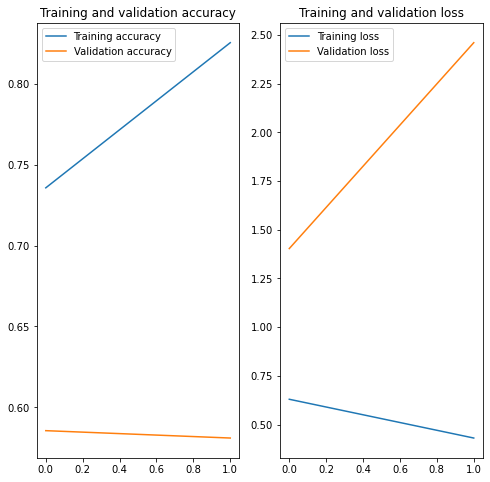

In [11]:
image_classifier = ImageClassifier(IMAGE_WIDTH, IMAGE_HEIGHT)
image_classifier.fit(epochs=2, save_path="ImageClassifier/ImageClassifier1.h5", show_training_results=True, 
                     dropout_rate=0, kernel_regularizer_l1=0.0, kernel_regularizer_l2=0.0)

In [ ]:
image_classifier = ImageClassifier(IMAGE_WIDTH, IMAGE_HEIGHT)
image_classifier.fit(epochs=30, save_path="ImageClassifier/ImageClassifier2.h5", show_training_results=True, 
                     dropout_rate=0.2, kernel_regularizer_l1=0.0, kernel_regularizer_l2=0.0)

In [ ]:
image_classifier = ImageClassifier(IMAGE_WIDTH, IMAGE_HEIGHT)
image_classifier.fit(epochs=30, save_path="ImageClassifier/ImageClassifier3.h5", show_training_results=True, 
                     dropout_rate=0.5, kernel_regularizer_l1=0.0, kernel_regularizer_l2=0.0)

In [ ]:
image_classifier = ImageClassifier(IMAGE_WIDTH, IMAGE_HEIGHT)
image_classifier.fit(epochs=30, save_path="ImageClassifier/ImageClassifier4.h5", show_training_results=True, 
                     dropout_rate=0.8, kernel_regularizer_l1=0.0, kernel_regularizer_l2=0.0)

In [ ]:
image_classifier = ImageClassifier(IMAGE_WIDTH, IMAGE_HEIGHT)
image_classifier.fit(epochs=30, save_path="ImageClassifier/ImageClassifier5.h5", show_training_results=True, 
                     dropout_rate=0.5, kernel_regularizer_l1=0.01, kernel_regularizer_l2=0.0)

In [ ]:
image_classifier = ImageClassifier(IMAGE_WIDTH, IMAGE_HEIGHT)
image_classifier.fit(epochs=30, save_path="ImageClassifier/ImageClassifier6.h5", show_training_results=True, 
                     dropout_rate=0.5, kernel_regularizer_l1=0.001, kernel_regularizer_l2=0.0)

In [ ]:
image_classifier = ImageClassifier(IMAGE_WIDTH, IMAGE_HEIGHT)
image_classifier.fit(epochs=30, save_path="ImageClassifier/ImageClassifier7.h5", show_training_results=True, 
                     dropout_rate=0.2, kernel_regularizer_l1=0.0, kernel_regularizer_l2=0.01)

In [ ]:
image_classifier = ImageClassifier(IMAGE_WIDTH, IMAGE_HEIGHT)
image_classifier.fit(epochs=30, save_path="ImageClassifier/ImageClassifier8.h5", show_training_results=True, 
                     dropout_rate=0.5, kernel_regularizer_l1=0.0, kernel_regularizer_l2=0.001)

In [ ]:
image_classifier = ImageClassifier(IMAGE_WIDTH, IMAGE_HEIGHT)
image_classifier.fit(epochs=30, save_path="ImageClassifier/ImageClassifier9.h5", show_training_results=True, 
                     dropout_rate=0.5, kernel_regularizer_l1=0.01, kernel_regularizer_l2=0.01)

In [ ]:
image_classifier = ImageClassifier(IMAGE_WIDTH, IMAGE_HEIGHT)
image_classifier.fit(epochs=30, save_path="ImageClassifier/ImageClassifier10.h5", show_training_results=True, 
                     dropout_rate=0.5, kernel_regularizer_l1=0.001, kernel_regularizer_l2=0.001)

In [ ]:
image_classifier = ImageClassifier(IMAGE_WIDTH, IMAGE_HEIGHT)
image_classifier.fit(epochs=30, save_path="ImageClassifier/ImageClassifier11.h5", show_training_results=True, 
                     dropout_rate=0.8, kernel_regularizer_l1=0.001, kernel_regularizer_l2=0.001)

In [ ]:
image_classifier = ImageClassifier(IMAGE_WIDTH, IMAGE_HEIGHT)
image_classifier.fit(epochs=30, save_path="ImageClassifier/ImageClassifier12.h5", show_training_results=True, 
                     dropout_rate=0.8, kernel_regularizer_l1=0.01, kernel_regularizer_l2=0.01)

In [ ]:
image_classifier = ImageClassifier(IMAGE_WIDTH, IMAGE_HEIGHT)
image_classifier.fit(epochs=30, save_path="ImageClassifier/ImageClassifier13.h5", show_training_results=True, 
                     dropout_rate=0.2, kernel_regularizer_l1=0.01, kernel_regularizer_l2=0.01)

In [ ]:
image_classifier = ImageClassifier(IMAGE_WIDTH, IMAGE_HEIGHT)
image_classifier.fit(epochs=30, save_path="ImageClassifier/ImageClassifier14.h5", show_training_results=True, 
                     dropout_rate=0.2, kernel_regularizer_l1=0.001, kernel_regularizer_l2=0.001)

In [ ]:
#captionGenerator = CaptionGenerator(IMAGE_WIDTH, IMAGE_HEIGHT)
#captionGenerator.generateCaption("D:/Cours/Cesi/A5/UE/Option - Data Science/Projet/Dataset soutenance/Text  (4).png")
#captionGenerator.generateCaption("D:/Cours/Cesi/A5/UE/Option - Data Science/Projet/Dataset soutenance/Paint  (1).jpg", 
#                                 prediction_model_path="ImageClassifier/ImageClassifierFullPainting.h5")